In [1]:
%cd ..
    


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
from notebooks.Utils import non_max_suppression

In [3]:
from ultralyticsplus import YOLO, render_result

# load model
model_yolov8 = YOLO('keremberke/yolov8m-table-extraction')

# set model parameters
model_yolov8.overrides['conf'] = 0.25  # NMS confidence threshold
model_yolov8.overrides['iou'] = 0.45  # NMS IoU threshold
model_yolov8.overrides['agnostic_nms'] = False  # NMS class-agnostic
model_yolov8.overrides['max_det'] = 1000  # maximum number of detections per image


In [4]:
from tblDetect.TableDetect import TableDetect
tblDec = TableDetect()

In [5]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests



# you can specify the revision tag if you don't want the timm dependency
processor_detr = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50") #, revision="no_timm")
model_detr = DetrForObjectDetection.from_pretrained("TahaDouaji/detr-doc-table-detection") #, revision="no_timm")

04/22/2024 17:12:17 - INFO - timm.models._builder -   Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
04/22/2024 17:12:17 - INFO - timm.models._hub -   [timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of the model checkpoint at TahaDouaji/detr-doc-table-detection were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model

In [15]:
import cv2
import numpy as np
font = cv2.FONT_HERSHEY_SIMPLEX 


def tblDec1(image, threshold = 0.1):
    scores, boxes = tblDec.detectTables(image, threshold = threshold)
    return scores, boxes

def tblDec2(image, threshold = 0.9):
    boxes = []
    labels = []
    scores = []
    results = model_yolov8.predict(image)
    
    for res in results:
        boxes.extend(res.boxes.xyxy.tolist())
        labels.extend(res.boxes.cls.tolist())
        scores.extend(res.boxes.conf.tolist())
    return scores, boxes, labels

def tblDec3(image, threshold = 0.1):
    inputs = processor_detr(images=image, return_tensors="pt")
    outputs = model_detr(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor_detr.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
    return results["scores"], results["boxes"]


In [7]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results_tbtr(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model_yolov8.model.names[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [8]:

# set image
image = "/Users/eliaweiss/Documents/doc2txt/lineCv/1/2.jpg"
# perform inference
results = model_yolov8.predict(image)

# observe results
print(results[0].boxes)



image 1/1 /Users/eliaweiss/Documents/doc2txt/lineCv/1/2.jpg: 640x480 1 bordered, 621.2ms
Speed: 3.9ms preprocess, 621.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2776])
data: tensor([[4.0262e+01, 1.8838e+03, 4.0691e+03, 2.4515e+03, 2.7761e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (5848, 4132)
shape: torch.Size([1, 6])
xywh: tensor([[2054.6753, 2167.6465, 4028.8259,  567.7660]])
xywhn: tensor([[0.4973, 0.3707, 0.9750, 0.0971]])
xyxy: tensor([[  40.2624, 1883.7635, 4069.0884, 2451.5295]])
xyxyn: tensor([[0.0097, 0.3221, 0.9848, 0.4192]])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


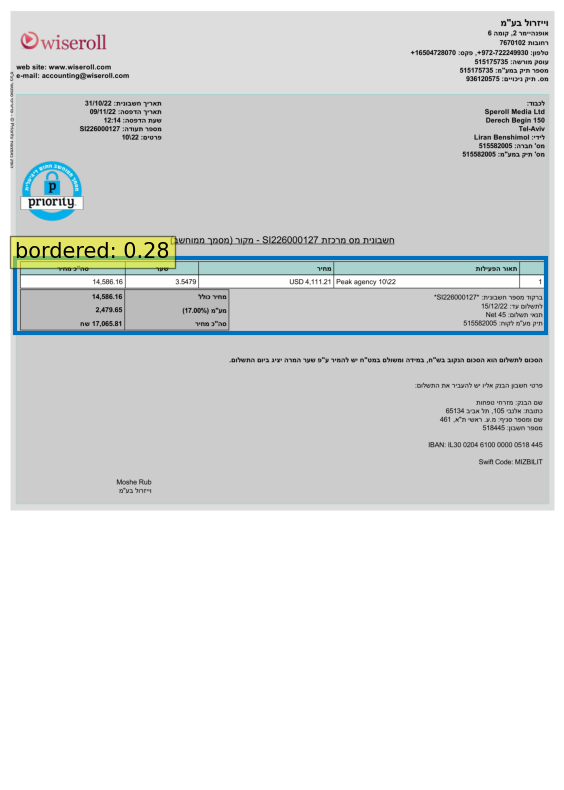

In [10]:
from PIL import Image
pil_img = Image.open(image)
plot_results_tbtr(pil_img,results[0].boxes.conf,results[0].boxes.cls, results[0].boxes.xyxy)

In [11]:
import random


def create_random_color():
    rgb = tuple(random.randint(0, 255) for _ in range(3))
    return rgb

In [12]:
import os
folder = "/Users/eliaweiss/Documents/doc2txt/lineCv/1"
# folder = "/Users/eliaweiss/Documents/doc2txt/sihach/Invoices/3/img3"
file_list = os.listdir(folder)
file_list = [file for file in file_list if 
             ".jpg" in file 
             or ".png" in file 
             or ".jpeg" in file]
file_list = sorted(file_list, key=lambda x: int(
    os.path.splitext(os.path.basename(x))[0]))

In [13]:
fileIter = iter(file_list)
cc = 0

In [16]:

while True:
    file_path = next(fileIter)
    if cc < 0:
        cc+=1    
        continue
    cc+=1    
    
    print(cc)
    
    file_path = os.path.join(folder, file_path)
    print(file_path)

    image = Image.open(file_path)
    scores, boxes = tblDec1(image)
    scores_t, boxes_t,_ = tblDec2(image)
    scores.extend(scores_t)
    boxes.extend(boxes_t)
    scores_t, boxes_t = tblDec3(image)
    scores.extend(scores_t)
    boxes.extend(boxes_t)    
    indices = non_max_suppression(boxes, scores, threshold=0.065)

    # Extract the final boxes after NMS
    boxes = [boxes[i] for i in indices]                             
    scores = [scores[i] for i in indices]
 
    tmpImg1 = np.array(image)    
    tmpImg1 = cv2.cvtColor(tmpImg1, cv2.COLOR_BGR2RGB)
    drawWidth = int(2 * tmpImg1.shape[0]*0.001)
    
    for score, box in zip(scores, boxes):
        box = [int(i) for i in box]
        score = f"{int(score*100)}"
        print("prob: ",score)
        l,b,r,t = box
        color = create_random_color()
        cv2.rectangle(tmpImg1,(l,t),(r,b),color,drawWidth)
   
        # Using cv2.putText() method 
        fontScale = drawWidth/2
        tmpImg1 = cv2.putText(tmpImg1, score, (l,t), font,  
                        fontScale, color, drawWidth) 
    cv2.imshow("nms",tmpImg1)    
    cv2.waitKey()
    

2
/Users/eliaweiss/Documents/doc2txt/lineCv/1/1.jpg

0: 640x480 2 borderlesss, 525.6ms
Speed: 1.6ms preprocess, 525.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
prob:  98
prob:  94
prob:  83
prob:  56
prob:  16
3
/Users/eliaweiss/Documents/doc2txt/lineCv/1/2.jpg

0: 640x480 1 bordered, 523.9ms
Speed: 2.0ms preprocess, 523.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
prob:  97
4
/Users/eliaweiss/Documents/doc2txt/lineCv/1/4.jpg

0: 640x480 (no detections), 508.8ms
Speed: 1.5ms preprocess, 508.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)
prob:  55
prob:  48
prob:  37
5
/Users/eliaweiss/Documents/doc2txt/lineCv/1/5.jpg

0: 640x416 2 bordereds, 1 borderless, 519.3ms
Speed: 1.8ms preprocess, 519.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)
prob:  99
prob:  98
6
/Users/eliaweiss/Documents/doc2txt/lineCv/1/6.jpg

0: 640x512 (no detections), 626.1ms
Speed: 2.9ms preprocess, 626.1ms inference, 0.7ms 

KeyboardInterrupt: 

In [ ]:

while True:
    file_path = next(fileIter)
    if cc < 0:
        cc+=1    
        continue
    cc+=1    
    
    print(cc)
    
    file_path = os.path.join(folder, file_path)
    print(file_path)

    image = Image.open(file_path)
    scores, boxes = tblDec1(image)
    
    # detect table
 
    tmpImg1 = np.array(image)    
    tmpImg1 = cv2.cvtColor(tmpImg1, cv2.COLOR_BGR2RGB)
    drawWidth = int(2 * tmpImg1.shape[0]*0.001)
    
    for score, box in zip(scores, boxes):
        box = [int(i) for i in box.tolist()]
        score = f"{int(score*100)}"
        print("prob: ",score)
        l,b,r,t = box
        color = create_random_color()
        cv2.rectangle(tmpImg1,(l,t),(r,b),color,drawWidth)
   
        # Using cv2.putText() method 
        fontScale = drawWidth/2
        tmpImg1 = cv2.putText(tmpImg1, score, (l,t), font,  
                        fontScale, color, drawWidth) 
    cv2.imshow("microsoft",tmpImg1)
        
        
    scores, boxes, labels = tblDec2(image)
    tmpImg2 = np.array(image)    
    tmpImg2 = cv2.cvtColor(tmpImg2, cv2.COLOR_BGR2RGB)
    
    for score, box, label in zip(scores, boxes, labels):
        box = [int(i) for i in box]
        label = model_yolov8.model.names[label]
        score = f"{int(score*100)}"
        print("prob: ",score)
        l,b,r,t = box
        color = create_random_color()
        cv2.rectangle(tmpImg2,(l,t),(r,b),color,drawWidth)
   
        # Using cv2.putText() method 
        fontScale = drawWidth/2
        tmpImg2 = cv2.putText(tmpImg2, score, (l,t), font,  
                        fontScale, color, drawWidth) 
    cv2.imshow("yolov8",tmpImg2)
    
    scores, boxes = tblDec3(image)
    tmpImg3 = np.array(image)    
    tmpImg3 = cv2.cvtColor(tmpImg3, cv2.COLOR_BGR2RGB)
    
    for score, box in zip(scores, boxes):
        box = [int(i) for i in box]
        score = f"{int(score*100)}"
        print("prob: ",score)
        l,b,r,t = box
        color = create_random_color()
        cv2.rectangle(tmpImg3,(l,t),(r,b),color,drawWidth)
   
        # Using cv2.putText() method 
        fontScale = drawWidth/2
        tmpImg3 = cv2.putText(tmpImg3, score, (l,t), font,  
                        fontScale, color, drawWidth) 
    cv2.imshow("detr",tmpImg3)    
                
    cv2.waitKey()
    # break